In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [2]:
df = pd.read_excel('marketing_campaign.xlsx')

In [3]:
# Check for exact row duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of exact duplicate rows: {duplicate_count}")

# Check for ID duplicates (different rows claiming to be the same person)
id_duplicates = df.duplicated(subset=['ID']).sum()
print(f"Number of duplicate IDs: {id_duplicates}")

# Remove duplicates (if any exist)
if duplicate_count > 0 or id_duplicates > 0:
    df = df.drop_duplicates(subset=['ID'], keep='first')
    print("Duplicates removed. Keeping the first occurrence.")

Number of exact duplicate rows: 0
Number of duplicate IDs: 0


In [4]:
# 1. Handle missing values
df['Income'] = df['Income'].fillna(df['Income'].median())

# 2. Drop zero-variance columns (Columns that don't change)
df.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True, errors='ignore')

# 3. Format dates for time-based analysis
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

In [5]:
# Calculate Customer Age
df['Age'] = 2024 - df['Year_Birth']

# Aggregate Total Spending across all 6 product categories
spend_cats = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spending'] = df[spend_cats].sum(axis=1)

# Simplify Family Structure
df['Children'] = df['Kidhome'] + df['Teenhome']
df['Is_Parent'] = np.where(df['Children'] > 0, 1, 0)

# Engagement Score (How many previous campaigns did they say 'Yes' to?)
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Total_Campaigns_Accepted'] = df[campaigns].sum(axis=1)

In [6]:
df = df[df['Age'] < 100]
df = df[df['Income'] < 200000]

In [7]:
# Group Marital Status into 'Partner' vs 'Alone'
df['Living_Status'] = df['Marital_Status'].replace({
    'Married': 'Partner', 'Together': 'Partner',
    'Absurd': 'Alone', 'Widow': 'Alone', 'YOLO': 'Alone', 
    'Divorced': 'Alone', 'Single': 'Alone', 'Alone': 'Alone'
})

# Encode Education to numbers (Graduation=1, PhD=2, etc.) for Correlation Matrix
le = LabelEncoder()
df['Education_Level'] = le.fit_transform(df['Education'])

Text(0.5, 1.0, 'Distribution of Customer Age')

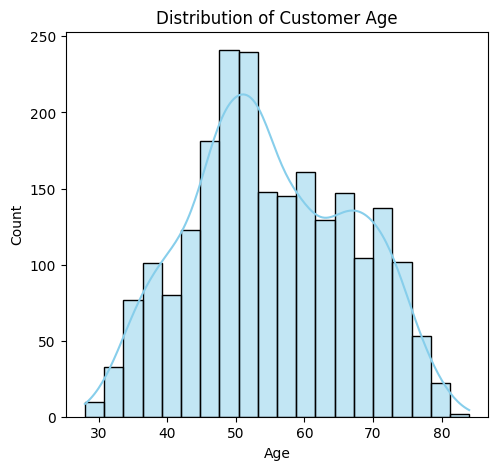

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Customer Age')

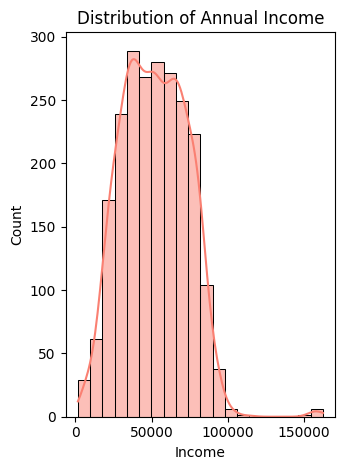

In [9]:
plt.subplot(1, 2, 2)
sns.histplot(df['Income'], bins=20, kde=True, color='salmon')
plt.title('Distribution of Annual Income')
plt.tight_layout()
plt.savefig('univariate_dist.png')

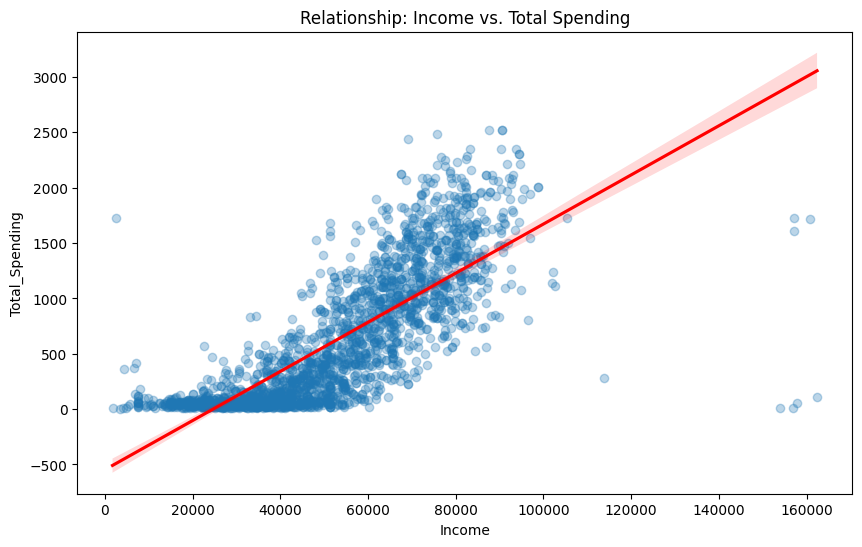

In [10]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Income', y='Total_Spending', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Relationship: Income vs. Total Spending')
plt.savefig('income_vs_spending.png')

C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\2226580822.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Children', y='Total_Spending', palette='Set2')


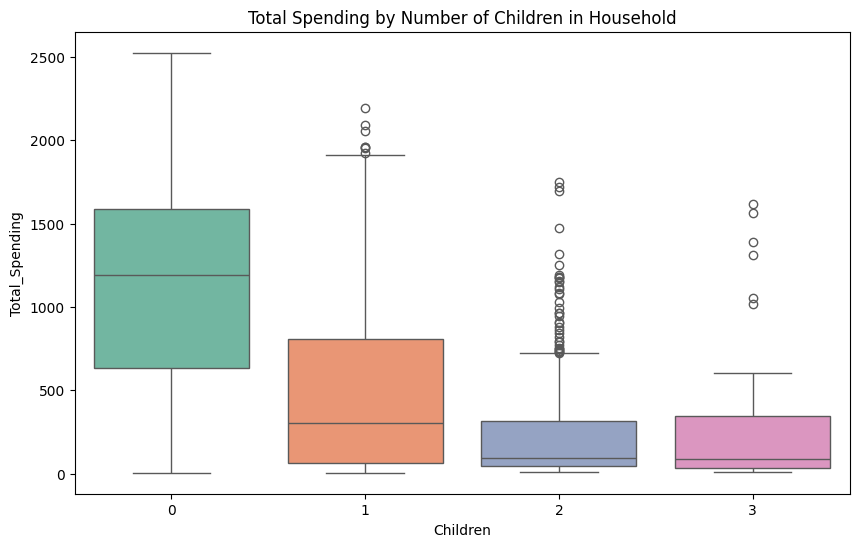

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Children', y='Total_Spending', palette='Set2')
plt.title('Total Spending by Number of Children in Household')
plt.savefig('spending_by_children.png')

C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\1586080384.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=melted_spend, x='Category', y='Amount', estimator=np.mean, palette='viridis')


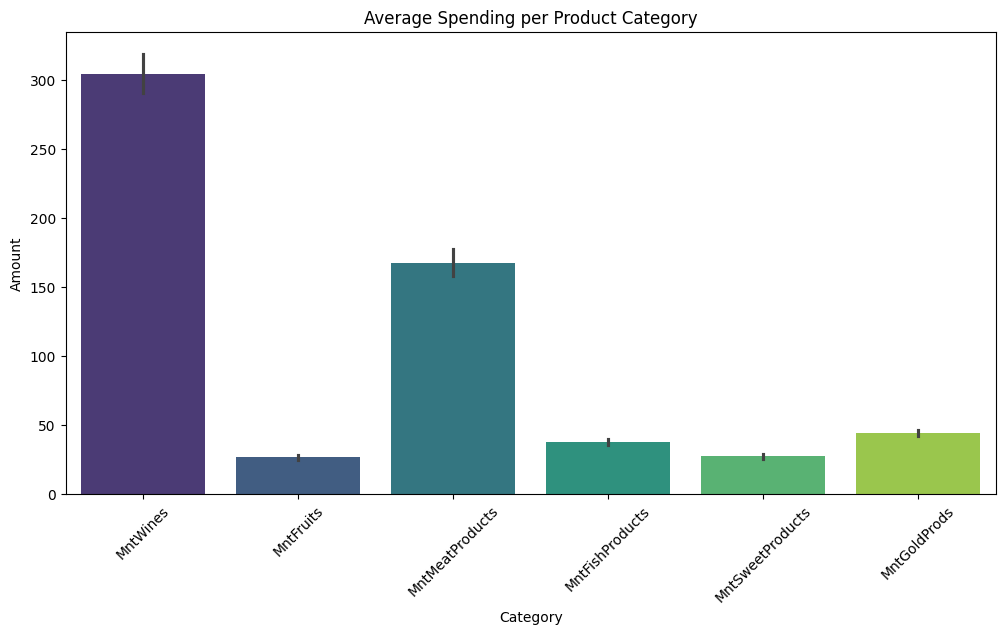

In [12]:
melted_spend = df.melt(id_vars=['ID'], value_vars=spend_cats, var_name='Category', value_name='Amount')
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_spend, x='Category', y='Amount', estimator=np.mean, palette='viridis')
plt.title('Average Spending per Product Category')
plt.xticks(rotation=45)
plt.savefig('category_spending.png')

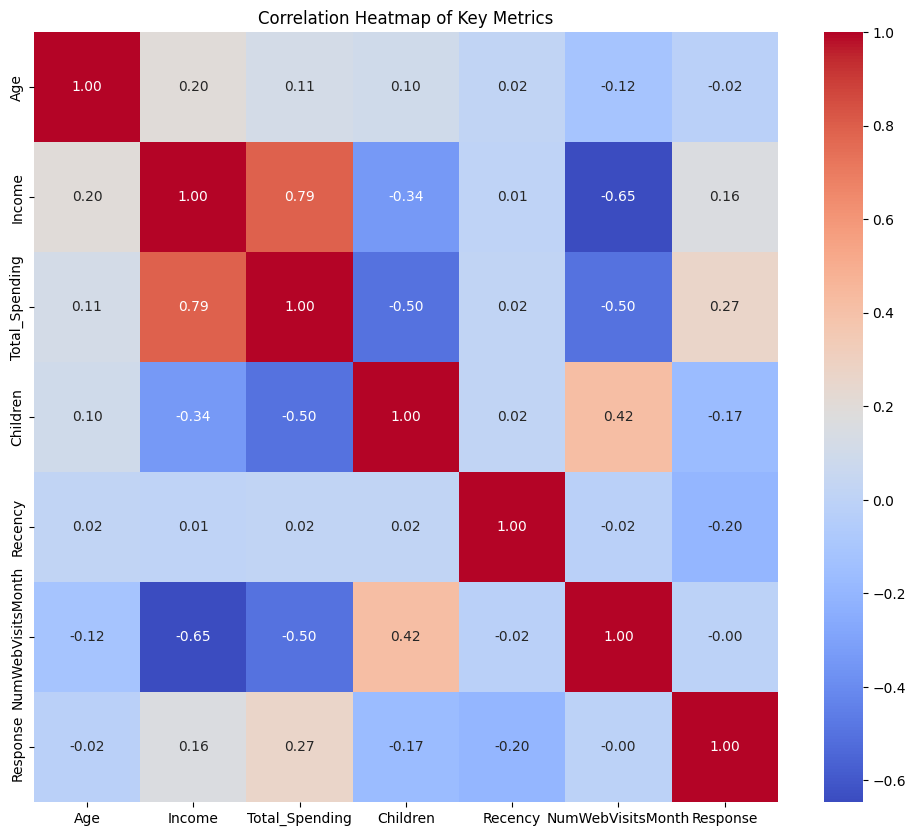

In [13]:
plt.figure(figsize=(12, 10))
corr_cols = ['Age', 'Income', 'Total_Spending', 'Children', 'Recency', 'NumWebVisitsMonth', 'Response']
correlation_matrix = df[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Key Metrics')
plt.savefig('correlation_heatmap.png')

C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\3752707860.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=campaign_success.index, y=campaign_success.values, palette='magma')


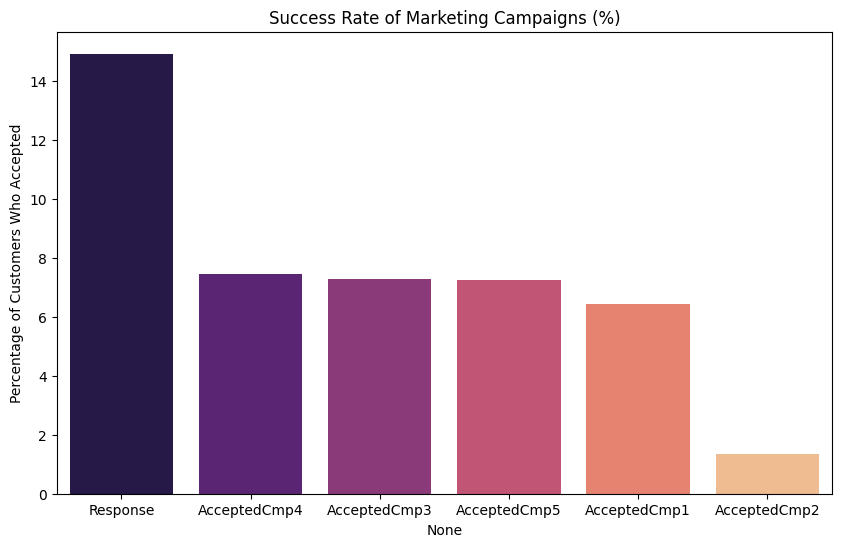

In [14]:
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
campaign_success = df[campaign_cols].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=campaign_success.index, y=campaign_success.values, palette='magma')
plt.title('Success Rate of Marketing Campaigns (%)')
plt.ylabel('Percentage of Customers Who Accepted')
plt.savefig('campaign_success_rates.png')

In [15]:
metrics_to_compare = ['Income', 'Total_Spending', 'Recency', 'NumWebVisitsMonth']
comparison = df.groupby('Response')[metrics_to_compare].mean()

print("Responders vs Non-Responders Mean Metrics:")
print(comparison)

Responders vs Non-Responders Mean Metrics:
                Income  Total_Spending    Recency  NumWebVisitsMonth
Response                                                            
0         50507.277340      539.009989  51.527865           5.323344
1         60183.244012      987.392216  35.383234           5.293413


C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\2706651624.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Response', y='Total_Spending', palette='Set1')


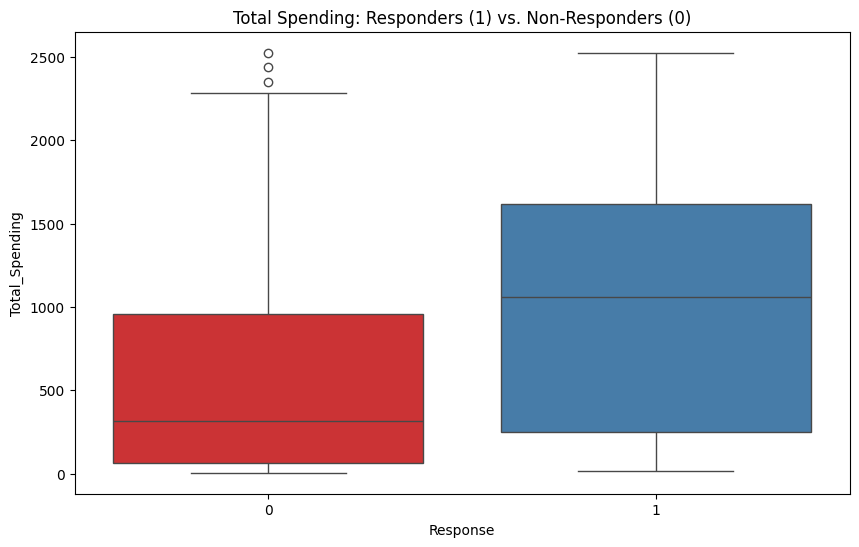

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Response', y='Total_Spending', palette='Set1')
plt.title('Total Spending: Responders (1) vs. Non-Responders (0)')
plt.savefig('spending_by_response.png')

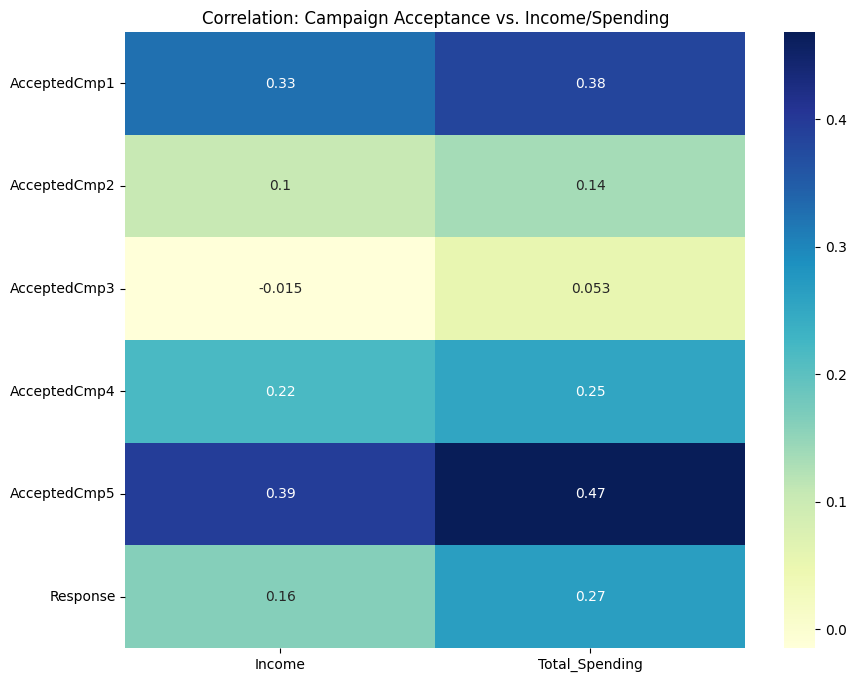

In [17]:
campaign_corr = df[campaign_cols + ['Income', 'Total_Spending']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(campaign_corr.loc[campaign_cols, ['Income', 'Total_Spending']], annot=True, cmap='YlGnBu')
plt.title('Correlation: Campaign Acceptance vs. Income/Spending')
plt.savefig('campaign_correlation.png')

In [18]:
df['Total_Accepted_Cmp'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)
loyalty_spend = df.groupby('Total_Accepted_Cmp')['Total_Spending'].mean()

print("\nAverage Spending by Number of Campaigns Accepted:")
print(loyalty_spend)


Average Spending by Number of Campaigns Accepted:
Total_Accepted_Cmp
0     478.529312
1     918.645062
2    1408.048193
3    1705.636364
4    1501.636364
Name: Total_Spending, dtype: float64


In [ ]:
# Calculate and print formatted values
comparison = df.groupby('Response')[['Income', 'Total_Spending', 'Recency', 'Children']].mean().round(1)

print(f"Income - Responders: ${comparison.loc[1, 'Income']:,.0f}, Non-Responders: ${comparison.loc[0, 'Income']:,.0f}")
print(f"Total Spending - Responders: ${comparison.loc[1, 'Total_Spending']:,.0f}, Non-Responders: ${comparison.loc[0, 'Total_Spending']:,.0f}")
print(f"Recency - Responders: {comparison.loc[1, 'Recency']:.0f} days, Non-Responders: {comparison.loc[0, 'Recency']:.0f} days")
print(f"Children - Responders: {comparison.loc[1, 'Children']:.1f}, Non-Responders: {comparison.loc[0, 'Children']:.1f}")

Income - Responders: $60,183, Non-Responders: $50,507
Total Spending - Responders: $987, Non-Responders: $539
Recency - Responders: 35 days, Non-Responders: 52 days
Children - Responders: 0.6, Non-Responders: 1.0


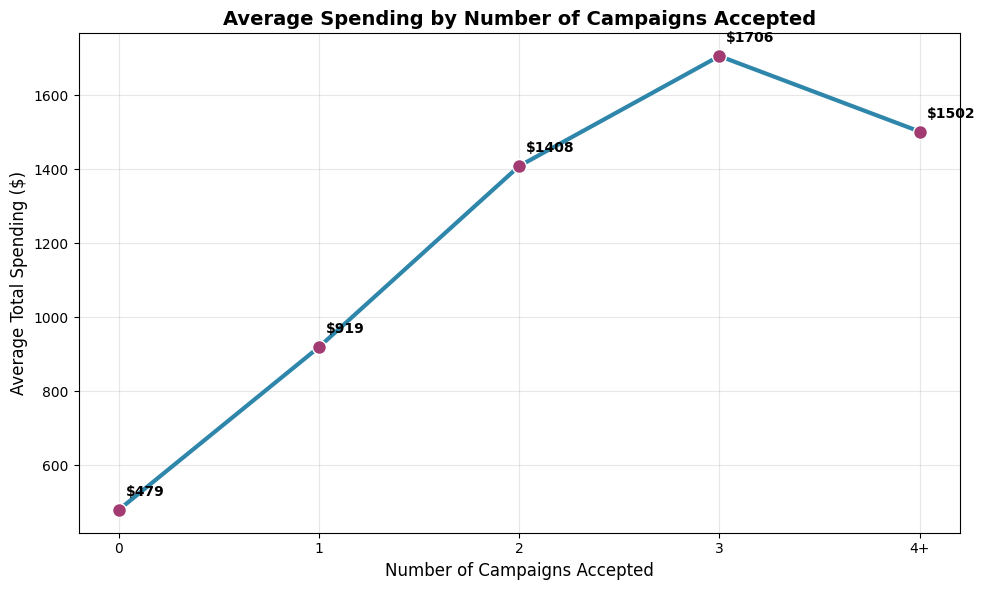

In [ ]:
# Line chart for loyalty spending trend
plt.figure(figsize=(10, 6))

plt.plot(loyalty_spend.index, loyalty_spend.values, marker='o', markersize=10, 
         linewidth=3, color='#2E86AB', markerfacecolor='#A23B72', markeredgecolor='white')

for i, v in enumerate(loyalty_spend.values):
    plt.annotate(f'${v:.0f}', (loyalty_spend.index[i], v), 
                xytext=(5, 10), textcoords='offset points', fontsize=10, fontweight='bold')

plt.title('Average Spending by Number of Campaigns Accepted', fontsize=14, fontweight='bold')
plt.xlabel('Number of Campaigns Accepted', fontsize=12)
plt.ylabel('Average Total Spending ($)', fontsize=12)
plt.xticks(range(5), ['0', '1', '2', '3', '4+'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('loyalty_spending_line.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\1467538376.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_spending = df.groupby('Age_Group')['Total_Spending'].agg(['mean', 'count', 'std']).round(1)
C:\Users\Nethma Karunarathne\AppData\Local\Temp\ipykernel_35532\1467538376.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=age_spending.index, y=age_spending['mean'], palette='viridis')


Average Spending by Age Group:
            mean  count    std
Age_Group                     
18-30      563.4      7  663.1
31-40      610.6    214  695.4
41-50      520.4    556  590.8
51-60      554.4    676  581.2
60+        710.4    783  585.2


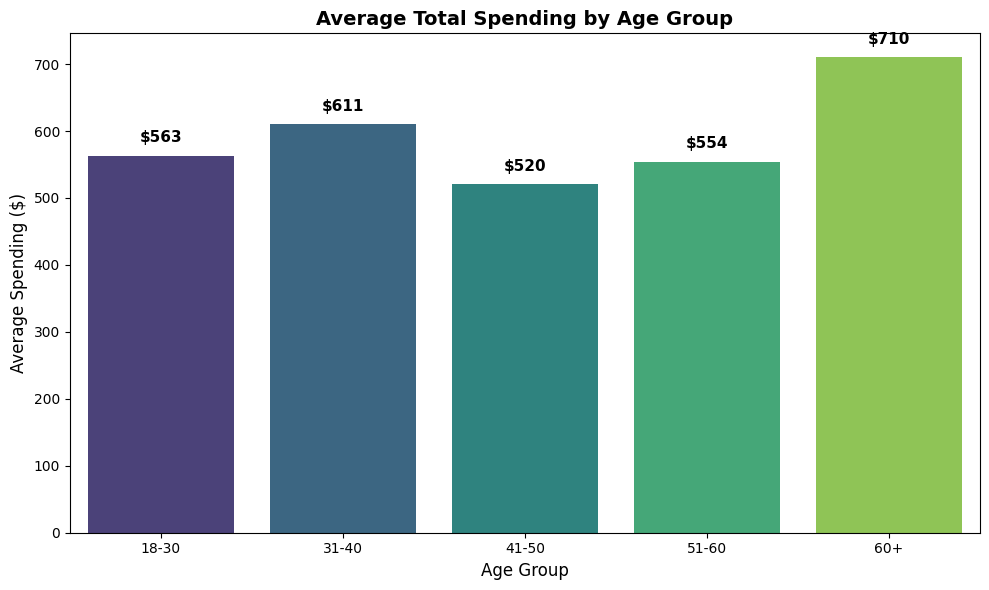

In [ ]:

bins = [18, 30, 40, 50, 60, 100]
labels = ['18-30', '31-40', '41-50', '51-60', '60+']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Calculate average spending by age group
age_spending = df.groupby('Age_Group')['Total_Spending'].agg(['mean', 'count', 'std']).round(1)
print("Average Spending by Age Group:")
print(age_spending)


plt.figure(figsize=(10, 6))
ax = sns.barplot(x=age_spending.index, y=age_spending['mean'], palette='viridis')
plt.title('Average Total Spending by Age Group', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Average Spending ($)', fontsize=12)

for i, v in enumerate(age_spending['mean']):
    ax.text(i, v + 20, f'${v:.0f}', ha='center', fontsize=11, fontweight='bold')
    
plt.tight_layout()
plt.savefig('spending_by_age.png', dpi=300, bbox_inches='tight')
plt.show()

Features Correlated with Campaign Response:
Response             1.000000
AcceptedCmp5         0.328148
AcceptedCmp1         0.293849
Total_Spending       0.265615
AcceptedCmp3         0.254106
AcceptedCmp4         0.176847
AcceptedCmp2         0.169234
Income               0.161121
NumWebVisitsMonth   -0.004397
Age                 -0.018557
Children            -0.169451
Recency             -0.198781
Name: Response, dtype: float64


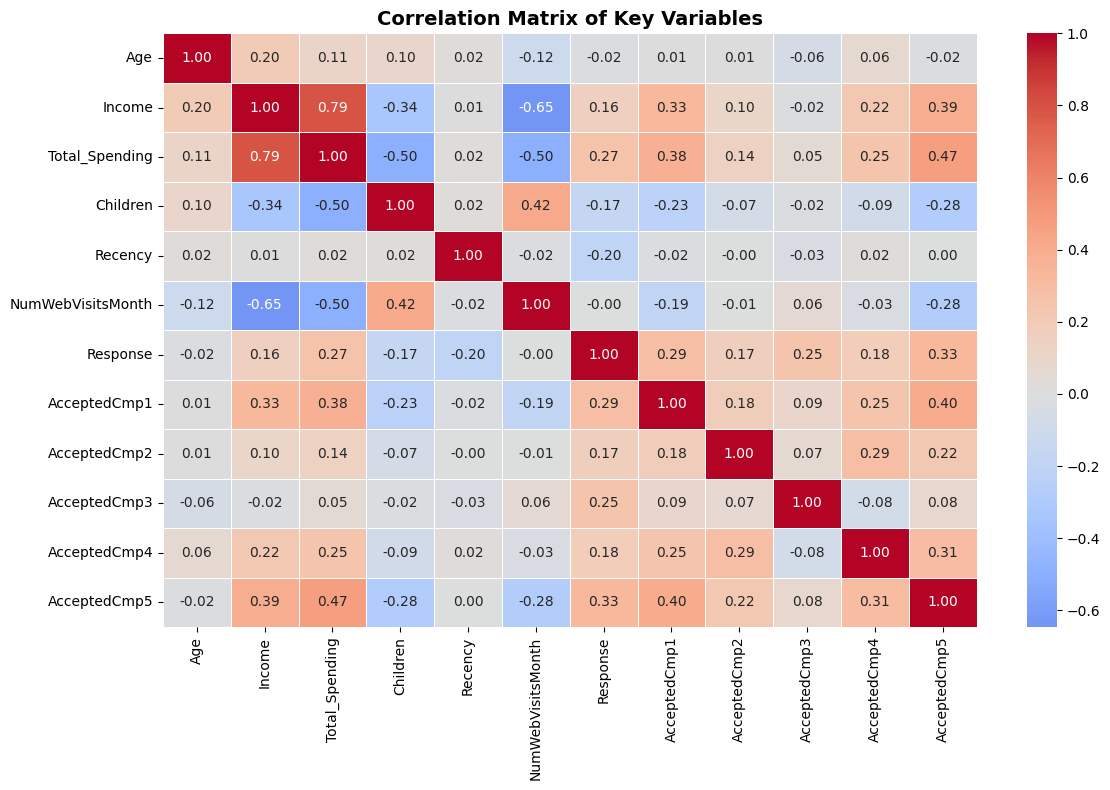

In [ ]:
numeric_cols = ['Age', 'Income', 'Total_Spending', 'Children', 'Recency', 
                'NumWebVisitsMonth', 'Response', 'AcceptedCmp1', 'AcceptedCmp2', 
                'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

correlation_matrix = df[numeric_cols].corr()

response_corr = correlation_matrix['Response'].sort_values(ascending=False)
print("Features Correlated with Campaign Response:")
print(response_corr)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Key Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('full_correlation_matrix.png', dpi=300)
plt.show()

In [26]:
cluster_features = ['Income', 'Total_Spending', 'Age', 'Children', 'Recency', 'NumWebVisitsMonth']
cluster_df = df[cluster_features].copy()


cluster_df = cluster_df.fillna(cluster_df.median())
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)


optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(cluster_scaled)


cluster_profile = df.groupby('Cluster').agg({
    'Income': 'mean',
    'Total_Spending': 'mean',
    'Age': 'mean',
    'Children': 'mean',
    'Recency': 'mean',
    'NumWebVisitsMonth': 'mean',
    'Response': 'mean',
    'ID': 'count'
}).round(1)

cluster_profile.columns = ['Avg_Income', 'Avg_Spending', 'Avg_Age', 'Avg_Children', 
                           'Avg_Recency', 'Avg_WebVisits', 'Response_Rate', 'Count']
cluster_profile['Response_Rate'] = (cluster_profile['Response_Rate'] * 100).round(1)
cluster_profile['Percentage'] = (cluster_profile['Count'] / cluster_profile['Count'].sum() * 100).round(1)

print("\nCustomer Segment Profiles:")
print(cluster_profile.sort_values('Avg_Spending', ascending=False))






Customer Segment Profiles:
         Avg_Income  Avg_Spending  Avg_Age  Avg_Children  Avg_Recency  \
Cluster                                                                 
2           78789.6        1418.2     54.6           0.1         50.1   
1           59102.8         745.7     61.5           0.9         48.3   
3           42664.5         190.0     58.7           2.1         50.2   
0           30598.9         128.8     46.5           0.8         48.5   

         Avg_WebVisits  Response_Rate  Count  Percentage  
Cluster                                                   
2                  2.4           30.0    491        22.0  
1                  5.2           10.0    660        29.5  
3                  6.4           10.0    437        19.5  
0                  7.0           10.0    648        29.0  
